In [21]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 32 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (18.3 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 121749 files and direc

In [19]:
import numpy as np
import copy

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.rc('font', family='NanumBarunGothic')

from sklearn import datasets
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

In [3]:
# 실험 재현성을 위해 시드 고정
# numpy random을 통해 임의 데이터 생성 시 난수를 고정하여도 반복적으로 생성하는 데이터가 같지는 않습니다.
# 다만 생성되는 데이터의 순서가 같아집니다.
seed=42
np.random.seed(seed)

## 1. 지표 소개 및 구현

각 지표를 구현하는 과정을 살펴보도록 하겠습니다. \
강의에서 수식을 통해 살펴보았던 각 지표들이 실제 코드 상으로 구현되는 과정을 익히는 것을 목표로 합니다.

In [4]:
y = np.array([3, 2, 4, 5, 1])
pred = np.array([2.8, 2.5, 3.5, 4.5, 1.5])

### 각 평가 지표 손계산
각 평가지표에 대해 손으로 우선 계산해보도록 하겠습니다. 칠판에 판서를 통해 진행하겠습니다.
이를 위한 평가 지표 공식은 아래와 같습니다.
- 정답 : y
- 예측값 : $\hat{y}$
#### Mean Error(평균 오차)
$ME = \sum_i^N y_i- \hat{y}_i$

#### Mean Absolute Error(평균 절대오차)
$MAE={1 \over N}\sum_i^N |y_i-\hat{y}_i| $

### Mean Absolute Percentage Error(평균 절대 비율 오차)
$MAPE = {1 \over N}{\sum^N_i |{y_i - \hat{y}_i \over y_i}| }$

#### Root Mean Suared Error(평균 제곱근 오차)
$RMSE=\sqrt{{1 \over N}\sum_i^N (y-\hat{y})^2}$

### 1-1. 평균 오차(Mean Error)

In [5]:
def get_ME(prediction, actual):
    # 평균 오차는 1) 실제 값과 예측 값의 차이를 모두 더한 후, 2) 데이터의 갯수로 나누면 됩니다. 이를 구현하면 아래와 같습니다.
    error = prediction - actual
    data_num = len(error)
    return np.sum(error) / data_num

### 1-2. 평균 절대 오차(Mean Absolute Error)

In [6]:
def get_MAE(prediction, actual) :
    # 평균 절대 오차는 1) 실제 값과 예측 값의 차이에 대해 절대값을 취하고 2) 이를 모두 더한 후, 3) 데이터의 갯수로 나누면 됩니다. 이를 구현하면 아래와 같습니다.
    error = prediction - actual
    abosulte_error = np.abs(error)
    data_num = len(error)
    return np.sum(abosulte_error) / data_num

### 1-3. 평균 절대 비율 오차(Mean Absolute Percentage Error)

In [7]:
def get_MAPE(prediction, actual, return_instance_wise_error=False):
    # 평균 절대 비율 오차는 1) 실제 값과 예측 값의 차이에 대해 절대값을 취하고 2) 이를 실제 값으로 나눈 후, 3) 이를 모두 더한 후, 4) 데이터의 갯수로 나누면 됩니다. 이를 구현하면 아래와 같습니다.
    error = prediction - actual
    abosulte_error = np.abs(error)
    percentage_error = abosulte_error / np.maximum(np.abs(actual), 1e-8) # 0으로 나누는 경우를 방지하기 위해 분모에 1e-8을 더해줍니다.
    data_num = len(error)
    mape = np.sum(percentage_error) / data_num
    if return_instance_wise_error:
        return mape, percentage_error
    return mape

### 1-4. RMSE(Root Mean Squared Error)

In [8]:
def get_RMSE(prediction, actual):
    # 평균 제곱근 오차는 1) 실제 값과 예측 값의 차이에 대해 제곱을 취하고 2) 이를 모두 더한 후, 3) 데이터의 갯수로 나눈 후, 4) 이를 제곱근을 취하면 됩니다. 이를 구현하면 아래와 같습니다.
    error = prediction - actual
    squared_error = np.square(error)
    data_num = len(error)
    return np.sqrt(np.sum(squared_error) / data_num)

In [9]:
def get_metric_manual(prediction, actual) :
    # 위에서 정의한 4가지 평가지표를 한번 산출하는 함수입니다.
    me = get_ME(prediction, actual)
    mae = get_MAE(prediction, actual)
    mape = get_MAPE(prediction, actual)
    rmse = get_RMSE(prediction, actual)
    return round(me, 4), round(mae, 4), round(mape, 4), round(rmse, 4)

위에서 선언한 다양한 함수들을 이용해 실제값과 예측값 사이의 지표를 구하는 코드는 아래와 같습니다.

In [10]:
me, mae, mape, rmse = get_metric_manual(pred, y)
print(f'ME: {me:.2f}, MAE: {mae:.2f}, MAPE: {mape:.2f}, RMSE: {rmse:.2f}')

ME: -0.04, MAE: 0.44, MAPE: 0.21, RMSE: 0.46


위 지표들은 모두 sklearn에서 지원하고 있습니다. \
향후 프로젝트 등에서 사용하실 일이 있으시다면 sklearn 등에서 사용하고자 하는 지표가 존재하는지 확인해보시기 바랍니다.
- sklearn 지표 리스트 : https://scikit-learn.org/stable/modules/model_evaluation.html

In [11]:
def get_metric_sklearn(prediction, actual) :
    # sklearn에서 제공하는 3가지 평가지표를 한번 산출하는 함수입니다.
    mse = mean_squared_error(actual, prediction)
    mae = mean_absolute_error(actual, prediction)
    mape = mean_absolute_percentage_error(actual, prediction)
    rmse = np.sqrt(mse)
    return round(mae, 4), round(mape, 4), round(rmse, 4)

In [12]:
mae, mape, rmse = get_metric_sklearn(pred, y)
print(f'MAE: {mae:.2f}, MAPE: {mape:.2f}, RMSE: {rmse:.2f}')

MAE: 0.44, MAPE: 0.21, RMSE: 0.46


### 1-5. 지표 해석
실습에서 다룬대로 지표 별로 해석하는 방법이 다르게 됩니다. \
만약 주가 예측 태스크였다고 가정한다면 위 세가지 지표는 아래와 같이 해석할 수 있습니다. \
- MAE : 예측된 주가와 실제 주가의 차이가 평균적으로 $0.44달러입니다.
- MAPE : 예측된 주가가 실제 주가 대비 평균 21%의 차이를 보였습니다.
- RMSE : 예측된 주가와 실제 주가 차이의 RMSE는 0.46입니다.

위와 같이 각 지표 별로 해석되는 방법은 다르며, 해석의 직관력과 실제 지표값의 타당성은 다른 관점입니다. \
RMSE는 MAE에 비해 직관적 해석은 힘들지만, 모델의 학습과 직접적으로 연관되어 있습니다. \
또한, RMSE는 제곱합 특성으로 인해 예측값이 실제값과 멀어질수록 더 큰 오차를 발생시키게 됩니다. \
이를 통해 예측 실패의 위험성을 고려할 수 있습니다.

## 2. MAE와 MAPE
가장 해석이 쉬운 두 지표 특성에 대해 알아보는 실험을 진행해보도록 하겠습니다.

### 2-1. 데이터 생성
실제값(y)과 예측값($\hat{y}$)을 임의로 생성해보겠습니다.

In [13]:
actuals = np.random.randint(0, 100, 100) # 0부터 100까지의 정수 중에서 100개를 랜덤으로 뽑습니다. 이를 실제값이라고 해봅시다.
predictions = actuals + np.random.normal(0, 3, 100) # 예측값은 실제값과 매우 작은 차이를 가진다고 하겠습니다.

for idx, (actual, prediction) in enumerate(zip(actuals, predictions)) :
    print('실제값 : {}, 예측값 : {}'.format(actual, prediction))
    if idx > 5 :
        break

실제값 : 51, 예측값 : 46.95996570791596
실제값 : 92, 예측값 : 89.35822620185868
실제값 : 14, 예측값 : 10.6083430859553
실제값 : 71, 예측값 : 71.40328664788406
실제값 : 60, 예측값 : 61.74636838413912
실제값 : 20, 예측값 : 22.663245378780072
실제값 : 82, 예측값 : 84.68299699032629


### 2-2. 지표 산출
사전에 정의한 get_metric_manual 함수를 통해 각 지표를 산출해보겠습니다.

In [14]:
me, mae, mape, rmse = get_metric_manual(predictions, actuals)
print(f'ME : {me:.4f}, MAE : {mae:.4f}, MAPE : {mape:.4f}, RMSE : {rmse:.4f}')

ME : 0.0099, MAE : 2.2153, MAPE : 0.1752, RMSE : 2.7831


### 2-3. MAPE 시각화 및 분석

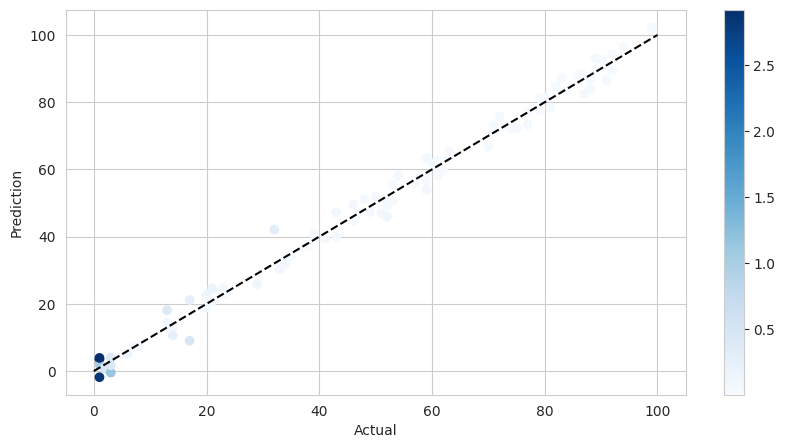

In [15]:
# 산점도를 통해 확인해봅시다.
## 산점도에서 실제값에 따른 MAPE도 함께 시각화하겠습니다.

sns.set_style('whitegrid')

mape, mape_instance = get_MAPE(predictions, actuals, return_instance_wise_error = True)

# 산점도를 그리기 위해 데이터를 정렬합니다.
sorted_idx = np.argsort(actuals)
actuals = actuals[sorted_idx]
predictions = predictions[sorted_idx]
mape_instance = mape_instance[sorted_idx]

# 산점도를 그립니다.
plt.figure(figsize=(10, 5))
plt.scatter(actuals, predictions, c=mape_instance, cmap='Blues')
plt.plot([0, 100], [0, 100], 'k--', alpha=1)
plt.xlabel('Actual')
plt.ylabel('Prediction')
plt.colorbar()
plt.show()

시각화 결과를 살펴보면, 색이 진할수록 MAPE가 큰 예측/실제값이라고 할 수 있습니다. \
이때 0에 가까운 매우 소수의 점에서 MAPE가 크게 나타나고, 나머지 점은 거의 MAPE가 발생하지 않는 것을 볼 수 있습니다. \
이는 오차의 절대 크기와 관계없이 실제값의 크기에 민감하게 반응하는 MAPE의 특징에 기인합니다. \
오차의 크기는 유지한 채, 실제값의 크기를 매우 크게 만들면 어떻게 변화하는지 살펴보겠습니다.

In [16]:
for idx, (pred, actual) in enumerate(zip(predictions, actuals)) :
    print('예측값       : {:.4f}, 실제값         : {:.4f}, 오차 : {:.4f}'.format(pred, actual, pred - actual))
    print('예측값 + 100 : {:.4f}, 실제값 + 100 : {:.4f}, 오차 : {:.4f}'.format(pred + 100, actual + 100, (pred + 100) - (actual + 100)))
    print('-------------------------------------------------')
    if idx > 5 :
        break

예측값       : 3.5044, 실제값         : 1.0000, 오차 : 2.5044
예측값 + 100 : 103.5044, 실제값 + 100 : 101.0000, 오차 : 2.5044
-------------------------------------------------
예측값       : -1.8292, 실제값         : 1.0000, 오차 : -2.8292
예측값 + 100 : 98.1708, 실제값 + 100 : 101.0000, 오차 : -2.8292
-------------------------------------------------
예측값       : 2.0195, 실제값         : 1.0000, 오차 : 1.0195
예측값 + 100 : 102.0195, 실제값 + 100 : 101.0000, 오차 : 1.0195
-------------------------------------------------
예측값       : 3.9189, 실제값         : 1.0000, 오차 : 2.9189
예측값 + 100 : 103.9189, 실제값 + 100 : 101.0000, 오차 : 2.9189
-------------------------------------------------
예측값       : 0.7689, 실제값         : 2.0000, 오차 : -1.2311
예측값 + 100 : 100.7689, 실제값 + 100 : 102.0000, 오차 : -1.2311
-------------------------------------------------
예측값       : 1.0721, 실제값         : 2.0000, 오차 : -0.9279
예측값 + 100 : 101.0721, 실제값 + 100 : 102.0000, 오차 : -0.9279
-------------------------------------------------
예측값       : 4.0366, 실제값         : 

실제값과 예측값의 차이는 동일한 상황에서 실제값의 크기가 커진 상황에서 평가지표들의 변화를 살펴보면 아래와 같습니다. \
MAPE를 제외한 지표들의 경우 오차를 그대로 활용하므로 변화가 없는 것을 알 수 있습니다. \
반면, MAPE의 경우 오차의 크기가 동일한 상황임에도, 실제값이 커지면 MAPE의 값이 매우 작아지는 것을 알 수 있습니다.

In [17]:
me, mae, mape, rmse = get_metric_manual(predictions, actuals)
print(f">>> 원래 데이터의 평가 지표                | ME : {me:.4f}, MAE : {mae:.4f}, MAPE : {mape:.4f}, RMSE : {rmse:.4f}")
me, mae, mape, rmse = get_metric_manual(predictions+100, actuals+100)
print(f">>> 모든 데이터에 100을 더한 경우의 평가 지표 | ME : {me:.4f}, MAE : {mae:.4f}, MAPE : {mape:.4f}, RMSE : {rmse:.4f}")

>>> 원래 데이터의 평가 지표                | ME : 0.0099, MAE : 2.2153, MAPE : 0.1752, RMSE : 2.7831
>>> 모든 데이터에 100을 더한 경우의 평가 지표 | ME : 0.0099, MAE : 2.2153, MAPE : 0.0152, RMSE : 2.7831


### 2-4. MAPE 변화 시각화

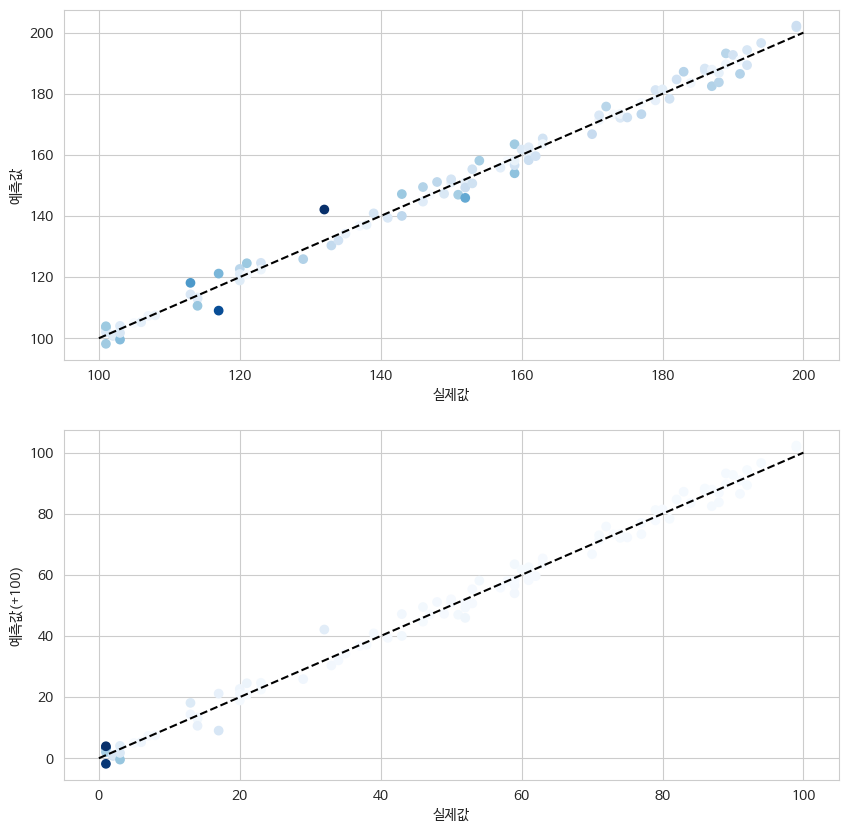

In [22]:
predictions_plus = predictions + 100
actuals_plus = actuals + 100

mape, mape_instance_original = get_MAPE(predictions, actuals, return_instance_wise_error = True)

# # plot 2 graph vertically
# fig, ax = plt.subplots(2, 1, figsize=(10, 10))
predictions_plus = predictions + 100
actuals_plus = actuals + 100

mape, mape_instance = get_MAPE(predictions_plus, actuals_plus, return_instance_wise_error=True)

# plot 2 graphs vertically
fig, ax = plt.subplots(2, 1, figsize=(10, 10))

# plot the first graph
ax[0].scatter(actuals_plus, predictions_plus, c=mape_instance, cmap='Blues')
ax[0].plot([100, 200], [100, 200], 'k--', alpha=1)
ax[0].set_xlabel('실제값')
ax[0].set_ylabel('예측값')
# fig.colorbar()

# plot the second graph
ax[1].scatter(actuals, predictions, c=mape_instance_original, cmap='Blues')
ax[1].plot([0, 100], [0, 100], 'k--', alpha=1)
ax[1].set_xlabel('실제값')
ax[1].set_ylabel('예측값(+100)')
# ax[1].colorbar()

plt.show()

실제값과 예측값이 동일하게 100만큼 커지자 MAPE가 비교적 균등하게 나타나는 것을 볼 수 있습니다. \
즉, MAPE는 실제값의 크기에 따라 오차를 다르게 반영하는 특징을 가지고 있습니다. \
이는 MAPE와 MAE가 활용되어야 하는 경우를 구분하는 중요한 지점이 됩니다. \
두 지표를 활용해야 하는 상황을 간략히 요약하면 아래와 같습니다.

- MAE : 실제 오차의 크기가 중요한 경우. (ex. 평점 예측, 전력 사용량 예측)
- MAPE : 실제값 크기 대비 오차의 크기가 중요한 경우. (ex. 자동차 배터리 잔량 예측, 주가 예측)

### 2-5. SKlearn 라이브러리 활용

실제 지표 사용 시에는 구현하지 않고, sklearn 내의 구현된 함수들을 사용하게 됩니다. \
위 구현체와 아래 함수의 결과는 구현 상의 차이로 다소 결과가 다를 수 있으나 해석은 동일하게 가능합니다. \
구현된 지표에 문제가 없는데, sklearn 지표와 성능이 다르게 나온다면, sklearn 내부에서 처리하는 이상치 예외 처리 등으로 인한 원인일 수 있습니다.

In [23]:
def get_metric(prediction, actual) :
    # sklearn의 mean_absolute_error, mean_squared_error, mean_absolute_percentage_error를 이용하여 MAE, RMSE, MAPE를 구하는 함수입니다.
    from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
    me = get_ME(prediction, actual)
    mae = mean_absolute_error(actual, prediction)
    mape = mean_absolute_percentage_error(actual, prediction)
    rmse =mean_squared_error(actual, prediction, squared=False) # squared=False를 통해 RMSE를 구할 수 있습니다.
    return round(me, 4), round(mae, 4), round(mape, 4), round(rmse, 4)

In [24]:
me, mae, mape, rmse = get_metric_manual(predictions, actuals)
print(f">>> 원래 데이터의 평가 지표          | ME : {me:.4f}, MAE : {mae:.4f}, MAPE : {mape:.4f}, RMSE : {rmse:.4f}")
me, mae, mape, rmse = get_metric(predictions, actuals)
print(f">>> sklearn의 함수를 이용한 평가 지표 | ME : {me:.4f}, MAE : {mae:.4f}, MAPE : {mape:.4f}, RMSE : {rmse:.4f}")

>>> 원래 데이터의 평가 지표          | ME : 0.0099, MAE : 2.2153, MAPE : 0.1752, RMSE : 2.7831
>>> sklearn의 함수를 이용한 평가 지표 | ME : 0.0099, MAE : 2.2153, MAPE : 0.1752, RMSE : 2.7831


## 3. 데이터 및 모델을 활용한 실습 1 (MAE가 중요한 경우)

직접 모델을 학습 및 평가하여 지표 별 활용 중요도를 확인해보도록 하겠습니다.

### 3-1. 데이터 생성

다섯개의 입력 변수를 이용하여 단일 수치를 예측하는 태스크를 활용해보겠습니다. \
이때, 해당 태스크를 전력 사용량 예측 태스크라고 간주한다면 입력 및 출력 변수는 다음과 같습니다. \
- 입력 변수 1 : 일자별 기온
- 입력 변수 2 : 일자별 습도
- 입력 변수 3 : 일자별 미세먼지 농도
- 입력 변수 4 : 전일 전력 사용량
- 입력 변수 5 : 10년 간 일별 평균 전력 사용량

- 출력 변수 : 해당 일자의 전력 사용량


In [25]:
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
X, y = make_regression(n_samples=10000, n_features=5, noise=10, random_state=seed) # 5개의 feature를 가진 데이터를 10000개 생성합니다.
y = y-np.min(y)

In [26]:
print(X.shape, y.shape) # 입력변수(X)와 출력변수(y) 모두 10000개의 데이터가 생성되었습니다.

(10000, 5) (10000,)


In [27]:
print("입력 변수 데이터 예시")
print(X[:3])
print("출력 변수 데이터 예시")
print(y[:3])

입력 변수 데이터 예시
[[ 0.01598377 -0.25042722 -0.19678183 -1.53218242  0.51152567]
 [ 0.82482016 -1.18387309  0.4974288   0.213996    2.29221164]
 [-1.56024198  1.85466213 -0.05435127 -0.91702803  1.13129905]]
출력 변수 데이터 예시
[417.87311647 476.69511807 491.75089605]


### 3-2. 데이터 시각화

1번 변수(일자별 온도)와 출력 변수(전력 사용량)의 상관관계를 보기 위해 시각화를 실행하겠습니다. \
임의로 생성한 데이터이므로 현실의 관계를 완전히 반영하지는 않으나 온도가 오를수록 전력 사용량이 오르는 관계를 확인할 수 있습니다.

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


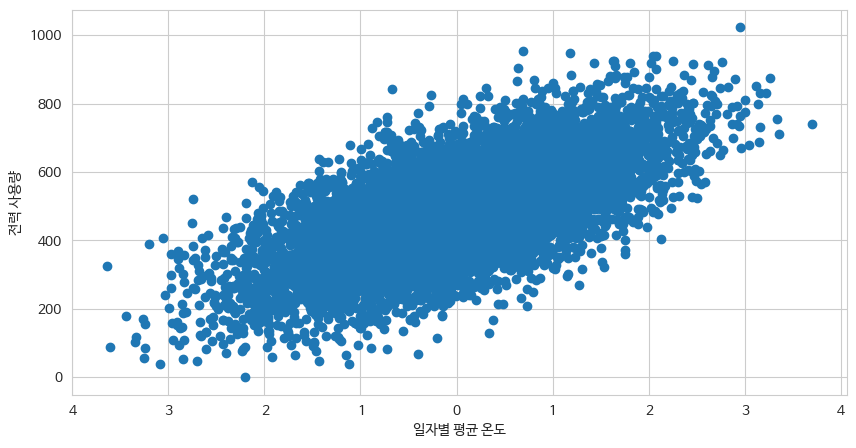

In [28]:
# plot X[1] vs y
plt.figure(figsize=(10, 5))
plt.scatter(X[:, 0], y)
plt.xlabel('일자별 평균 온도')
plt.ylabel('전력 사용량')
plt.show()

### 3-3. 후보 모델군

실습에서 사용할 모델은 다음과 같습니다. 오늘 강의는 각 모델에 대한 이해가 목표가 아니기 때문에, 아래와 같이 간략한 설명으로 대체하겠습니다. \
다만, 실제 과업 수행을 위해서는 다양한 모델을 후보로 삼을 필요가 있고, 후보 모델에 대한 평가 진행 시 목적에 적합한 평가 지표를 선택해야 한다는 점만 살펴보도록 하겠습니다.

1. 선형회귀 : 전통적인 통계 기반의 예측 및 분석 방법론으로, 주어진 학습 데이터 내 최적의 설명 가능한 직선을 찾습니다.
2. 랜덤포레스트 : 의사결정나무 기반의 방법론으로 매우 많은 의사결정나무들을 이용하여 단일 예측값을 산출합니다.

In [29]:
linear_regression = LinearRegression()
random_forest = RandomForestRegressor()

### 3-4. 실제 데이터 분할

주어진 데이터를 분할하여 학습/평가/테스트 용 데이터를 생성하도록 하겠습니다. \
이때 테스트용 데이터는 실제 서비스 적용 상황이라 가정하고, 모델 평가에 반영되지 않습니다. \
모델 개발 시에는 기존에 확보된 데이터를 이용하여 최적의 모델을 학습/선정해야 하기 때문에, 학습 및 평가 데이터를 이용하게 됩니다.

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=seed)

### 3-5. 모델 학습
사전에 정의한 두가지 모델에 대해 학습 데이터를 이용하여 학습을 진행하도록 하겠습니다. \
모델 학습은 주어진 데이터에 대해 예측을 잘 수행하도록 모델을 조정하는 과정이라 할 수 있습니다.

In [31]:
linear_regression.fit(X_train, y_train)
random_forest.fit(X_train, y_train)

RandomForestRegressor()

### 3-6. 모델 평가 및 수치 해석

위에서 작성된 함수들을 바탕으로 실제 모델을 훈련 및 평가하도록 하겠습니다.
평가 방식은 모델과 관계없이 동일하게 진행되므로, 평가를 위한 함수 역시 선언하도록 하겠습니다.

In [32]:
def evaluate_model(model, X_val, y_val) :
    # 주어진 전체 데이터를 이용하여 모델을 훈련하고, 전체 데이터에 대한 평가지표를 구하는 함수입니다.
    prediction = model.predict(X_val)
    me, mae, mape, rmse = get_metric(prediction, y_val)
    # return {"ME" : me, "MAE" : mae, "MAPE" :mape, "RMSE" : rmse}
    return [me, mae, mape, rmse], model

In [33]:
result_df = pd.DataFrame(columns = ["model", "ME", "MAE", "MAPE", "RMSE"])

print(">>> Linear Regression")
linear_regression_result, model = evaluate_model(linear_regression, X_val, y_val)
result_df.loc[0] = ["linear_regression"] + linear_regression_result

print(">>> Random Forest")
random_forest_result, model = evaluate_model(random_forest, X_val, y_val)
result_df.loc[1] = ["random_forest"] + random_forest_result

result_df

>>> Linear Regression
>>> Random Forest


,model,ME,MAE,MAPE,RMSE
0,linear_regression,0.0163,8.1031,0.0185,10.1642
1,random_forest,0.1548,11.7038,0.0294,16.1319


Validation Set을 통한 성능 평가 결과를 해석해보면 아래와 같습니다.
1. MAE : 선형회귀가 랜덤포레스트 대비 전력량 예측에 있어 약 3.6 KW 전력량의 오차가 적음
2. MAPE : 선형회귀가 랜덤포레스트 대비 전령량 예측에 있어 약 1.1%p 전력량 오차가 적음

위 두가지 해석을 이용하여 향후 전력량 확보 방안을 논의한다고 생각해봅시다.
- MAE 사용 시 : 약 5KW의 예비 전력 확보 필요
- MAPE 사용 시 : 예측량 대비 약 2%의 예비 전력 확보 필요

의사결정 과정을 고려한다면 MAE를 이용하는 것이 해석이 용이하고 향후 활용이 용이할 수 있다는 점을 알 수 있습니다. \
MAPE를 활용한다면 다소 모호한 예측이 수행됨을 알 수 있습니다.

## 4. 데이터 및 모델을 활용한 실습 2 (MAPE가 중요한 경우)

MAPE가 중요한 경우는 실제값의 크기 대비 오차의 크기를 비교할 필요가 있을 경우입니다. \
이번 실습에서는 익일 주가 예측 태스크를 가정하고 진행하도록 하겠습니다. \
이때 입력 변수는 5가지 경제지표로 하고, 출력변수를 익일 주가로 하겠습니다.

### 4-1. 데이터 생성

In [34]:
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
X, y = make_regression(n_samples=10000, n_features=5, noise=10, random_state=seed) # 5개의 feature를 가진 데이터를 10000개 생성합니다.
y = y

In [35]:
print(X.shape, y.shape) # 입력변수(X)와 출력변수(y) 모두 10000개의 데이터가 생성되었습니다.

(10000, 5) (10000,)


In [36]:
print("입력 변수 데이터 예시")
print(X[:3])
print("출력 변수 데이터 예시")
print(y[:3])

입력 변수 데이터 예시
[[ 0.01598377 -0.25042722 -0.19678183 -1.53218242  0.51152567]
 [ 0.82482016 -1.18387309  0.4974288   0.213996    2.29221164]
 [-1.56024198  1.85466213 -0.05435127 -0.91702803  1.13129905]]
출력 변수 데이터 예시
[-70.45555225 -11.63355066   3.42222732]


### 4-2. 데이터 시각화

1번 센서 데이터와 잔여 주행거리 데이터 간의 상관관계를 관찰하기 위해 시각화를 실행해보겠습니다. \
1번 센서 데이터의 값이 클수록 잔여 주행거리가 많은 것을 확인할 수 있습니다.

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


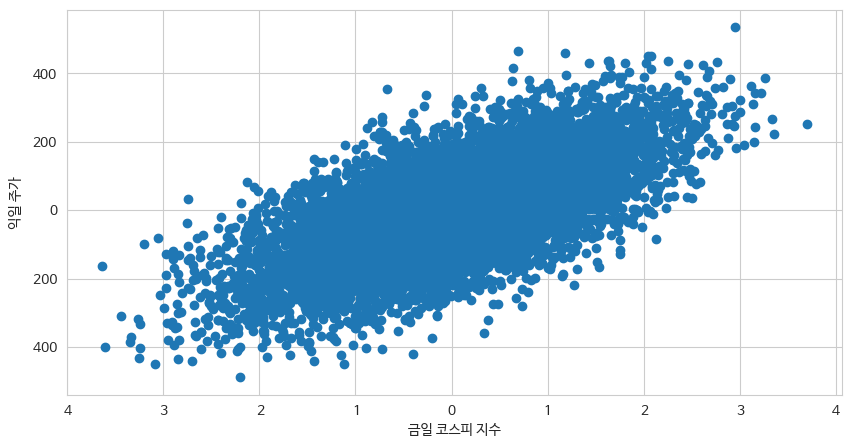

In [37]:
# plot X[1] vs y
plt.figure(figsize=(10, 5))
plt.scatter(X[:, 0], y)
plt.xlabel('금일 코스피 지수')
plt.ylabel('익일 주가')
plt.show()

### 4-3. 데이터 분할
주어진 데이터를 분할하여 학습/평가/테스트 용 데이터를 생성하도록 하겠습니다. \
이때 테스트용 데이터는 실제 서비스 적용 상황이라 가정하고, 모델 평가에 반영되지 않습니다. \
모델 개발 시에는 기존에 확보된 데이터를 이용하여 최적의 모델을 학습/선정해야 하기 때문에, 학습 및 평가 데이터를 이용하게 됩니다.

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=seed)

### 4-4. 후보 모델 학습

In [39]:
linear_regression = LinearRegression()
random_forest = RandomForestRegressor()

In [40]:
linear_regression.fit(X_train, y_train)
random_forest.fit(X_train, y_train)

RandomForestRegressor()

### 4-5. 후보 모델 평가 및 수치 해석
3번 항목에서 진행했던 평가 함수를 이용하여 평가를 진행하겠습니다.

In [41]:
result_df = pd.DataFrame(columns = ["model", "ME", "MAE", "MAPE", "RMSE"])

print(">>> Linear Regression")
linear_regression_result, linear_model = evaluate_model(linear_regression, X_val, y_val)
result_df.loc[0] = ["linear_regression"] + linear_regression_result

print(">>> Random Forest")
random_forest_result, rf_model = evaluate_model(random_forest, X_val, y_val)
result_df.loc[1] = ["random_forest"] + random_forest_result

result_df

>>> Linear Regression
>>> Random Forest


,model,ME,MAE,MAPE,RMSE
0,linear_regression,0.0163,8.1031,0.3058,10.1642
1,random_forest,0.2376,11.6081,0.4359,16.0242


태스크가 전령 사용량 예측에서 자동차 배터리 잔량 예측 태스크로 변경되어 해석이 달라질 수 있습니다. \

위 결과에 대해 해석하면 아래와 같습니다.
1. MAE : 선형회귀가 랜덤포레스트 대비 주가 예측에 있어 3.5만원 더 정확한 예측을 수행합니다.  
2. MAPE : 선형회귀가 랜덤포레스트 대비 실제 주가와 15% 정확한 예측을 보이고 있습니다.

위 해석을 실제 서비스 상황과 연결지어 생각해보겠습니다. \
선형회귀에 성능에 대해 해석해보면 다음과 같습니다. \

1번 해석을 이용할 경우 실제 주가와 별개의 해석이 이루어집니다. \
- 실제 주가가 1만원이었을 때, 9.1만원으로 예측한다고 해석될 수 있습니다.
- 실제 주가가 100만원이었을 때, 108.1만원으로 예측한다고 해석될 수 있습니다.

2번 해석을 이용할 경우 실제 주가와 연동한 해석이 가능합니다. \
- 실제 주가가 1만원이었을 때, 1.3만원으로 예측한다고 해석될 수 있습니다.
- 실제 주가가 100만원이었을 때, 130만원으로 예측한다고 해석될 수 있습니다.

위와 같은 해석의 차이는 MAPE와 MAE 평가 방식의 차이에 기인합니다. 또한, MAE 대비 MAPE가 실제값을 고려한 수치 계산으로 해석의 장점이 있음을 확인할 수 있습니다.